誰適合閱讀這篇文章：初階到中階 python 基礎的程式設計師，想深入淺出的了解 python 的位元組碼（bytecode）

PyCon 2016 有一場很有趣的演講，內容是關於介紹 Python 位元組碼（Python Bytecode），演講名稱就稱為 ["Playing Bytecode with Python"][btalk]。這場演講有趣的地方，在於它完全表達了 Python 社群的精神，也就是以 [“Monty Python”][mp] 的方式來表達一個抽象複雜的概念。在有如勞萊與哈台兩人一搭一唱的方式，傳遞了如論語般藉由孔子和弟子們的對話傳遞了儒道的精神，或柏拉圖和色諾芬以與蘇格拉底對話錄的方式來闡述知識的進程。   

<a name="more"></a>

不過其實整篇演講，並沒有傳遞如此深奧的學問。多半是從大約 30 分鐘的演講中，發現自己摸索學習程式的影子。例如，因為毫無頭緒，只好用嘗試錯誤法，從錯誤中學習。誠如各位會在影片中看到的，在毫無頭緒的情況下，隨機 import 一個看起來很相關的模組，然後逐一檢查嫌疑 function（如其中一位講者在演講中所表演的，有著雙底線開頭的 function 通常是秘密 function 如 \_\_code\_\_）等等。曾經與頑固的電腦奮鬥好幾小時以上，卻又樂此不疲的編程者，看完應該會有（像我這樣很遜的編程者）“會心一笑“ 或（駭客級的編程者）“哄堂大笑” 的結果。  

我此篇的教學文章的內容大致以此篇演講為主，另外再增加一些 PyCon 2017 年中另一場演講：利用 python 3.6 新的 frame evaluation API 來打造更快更強的[除錯器][pycdbg]。用此篇演講來簡述位元組碼可能的實際應用，希望大家在歡樂觀看影片之餘，也能夠增長知識。首先，什麼是位元組碼，我們可以用以下的 add function 物件來做解釋。

[btalk]:https://youtu.be/mxjv9KqzwjI
[mp]:https://en.wikipedia.org/wiki/Monty_Python
[pycdbg]:https://youtu.be/NdObDUbLjdg

In [3]:
def add(a, b):
  return a + b

誠如大家都能琅琅上口的事實，“python 程式裡都是物件”，所以 add 本身是一個 function 物件。至於 add 本身執行的邏輯，我們可以存取 add 物件的 \_\_code\_\_ 屬性而得到已編譯完成的 Code 物件。而名為 add 的 function 物件，所編譯而成的位元組碼，則可以藉由存取其 Code 物件的 co_code 成員而得。其結果以 byte string 表示如下：

In [7]:
add.__code__.co_code

b'|\x00\x00|\x01\x00\x17S'

我們可以利用 list comprehension 把位元組碼轉成十進位的整數來看。不過就算把 byte 翻成整數來看，仍舊是一頭霧水。

In [8]:
list(add.__code__.co_code)

[124, 0, 0, 124, 1, 0, 23, 83]

看來我們需要一個解譯器來為我們翻譯上面神秘的密碼。幸好 python 的開發者們很佛心的提供了 dis 模組。只要 ```import dis``` （可別手誤，打成 ```import this```）並呼叫了同名的模組方法，來為我們揭開神秘的面紗。

In [13]:
import dis
dis.dis(add)

  2           0 LOAD_FAST                0 (a)
              3 LOAD_FAST                1 (b)
              6 BINARY_ADD
              7 RETURN_VALUE


python 直譯器可以看成一個利用堆疊（stack）來實踐位元組碼執行的虛擬機器，其作用方式和真實的中央處理單元（CPU）很相像，只不過是用軟體去提取並執行 python 直譯器定義的位元組碼，而非與作業系統和硬體相依的機械碼。所以 dis.dis 的輸出可以看成是一個位元組碼執行狀態的歷程。這個輸出總共有六個欄位：

首先第一個欄位是原始碼的列數。在這裡就是原始碼第二列，也就是 ```return a + b``` 這行程式碼。下一個欄位，全部都是空白的，則是用來標示一些符號，如 conditional jump (if-else)，我們會在後面的實際例子看到這個欄位的輸出。第三個欄位則是位元組碼的位移。第四個欄位則是位元組碼指令的名稱。第五個欄位，則是 0 開始的索引值，用來讀取 python 堆疊（value stack）位元組碼指令的引數。最後一個欄位則是原始碼中相對應的變數符號。  

從 dis.dis 輸出的第三欄，可以看得出來，python 的位元組碼可以分為以 3 個 byte 為單位的指令：第一個 byte 是儲存位元組碼的指令，剩下兩個 byte 則是用來儲存位元組碼指令所需的輸入。眼尖的讀者可能會發現，根據位元組碼位移， **BINARY_ADD** 指令的大小只有一個 byte。這是因為它所做的就是將 python 堆疊最上層的兩個數值相加。而這兩個數值，已經經由 **LOAD_FAST** 指令，從堆疊載入到 python 的執行環境中。

下圖就是堆疊如何執行 **BINARY_ADD** 指令的示意圖。可以看到，堆疊會先進行兩個 pop 的動作，在 python 直譯器看來兩個 **LOAD_FAST** 指令，執行完 **BINARY_ADD** 後，再把結果 push 到堆疊裡，也就是執行 **STORE_FAST** （見下面的例子） 的指令。（圖片來源：[Engineering The Code][stackpng]）

[stackpng]:https://markfaction.wordpress.com/2012/07/15/stack-based-vs-register-based-virtual-machine-architecture-and-the-dalvik-vm/

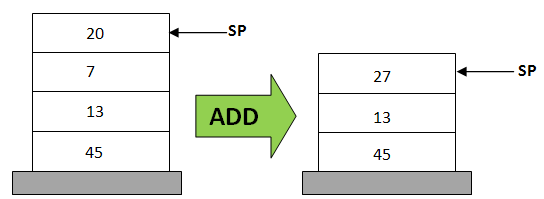

In [3]:
#ignore
from IPython.display import Image
Image(filename='../../../../files/2017/11/stackadd.png', metadata={'alt': 'BINARY_ADD 示意圖'})

我們可以看更多的例子，以下是另外一個解譯器對 ```add_with_assign``` function 物件的輸出，可以看到因為原始碼有兩行，我們可以看到第一欄多了一個 3，表示是原始碼中第三行或是 ```return x``` 程式碼。同時我們也看到了新的位元碼指令：**STORE_FAST**，這個指令則是將新的變數從執行環境推到 python 堆疊裡。

In [15]:
def add_with_assign(a, b):
  x = a + b
  return x

dis.dis(add_with_assign)

  2           0 LOAD_FAST                0 (a)
              3 LOAD_FAST                1 (b)
              6 BINARY_ADD
              7 STORE_FAST               2 (x)

  3          10 LOAD_FAST                2 (x)
             13 RETURN_VALUE


以下的輸出則是包含 if-else 的程式碼，可以看到第二欄出現了 >> 指標，表示若 x <= 0，程式的執行就會跳到 else 的區塊去完成，也就是位元組碼位移為 16 的地方。而更多關於 dis 的程式和更詳盡的 python 位元組碼指令介紹可以參看這篇英文的[教學文][lop]。
[lop]:https://renewang.github.io/land_of_plenty/posts/learning-cpython-internals-interpreter-and-source-code-overview/

In [16]:
def abs(x):
  if x > 0:
    return x
  else:
    return -x

dis.dis(abs)

  2           0 LOAD_FAST                0 (x)
              3 LOAD_CONST               1 (0)
              6 COMPARE_OP               4 (>)
              9 POP_JUMP_IF_FALSE       16

  3          12 LOAD_FAST                0 (x)
             15 RETURN_VALUE

  5     >>   16 LOAD_FAST                0 (x)
             19 UNARY_NEGATIVE
             20 RETURN_VALUE
             21 LOAD_CONST               0 (None)
             24 RETURN_VALUE


不過，既然位元組碼是屬於 Code 物件的一部分，那麼是否我們能直接用 Code 物件來建立同樣功能的 function 呢？演講中提供了一個方法，直接用 types 模組中 CodeType 來建構一個 Code 物件。這個 Code 物件可以完成和 addone function 相同的功能。先來看看 dis 對 addone function 的解譯。

In [18]:
def addone(x):
  return x + 1

dis.dis(addone)

  2           0 LOAD_FAST                0 (x)
              3 LOAD_CONST               1 (1)
              6 BINARY_ADD
              7 RETURN_VALUE


CodeType 需要一些特別的參數，這些參數大致上可以從以下原始碼旁的註解知道他們的用途。不過還是在這裡做一個快速介紹：前兩個 CodeType 的引數是傳入要建構的 Code 物件的引數數目，和 keyword 引數的引數數目，因為 `addone` function 只有一個引數 `x` 且沒有 keyword 引數，所以分別傳入 1 和 0 即可。同時，在變數名稱上要記得給定一個 tuple 物件，裡面裝的就是引數的變數名稱。其次，因為在 `addone` function 的作用域（scope）裡雖然並沒有任何變數被宣告，只有傳入的引數，`x`，所以在局部變數（local variable）的數目，我們一樣要填 1。  
  
另外，要注意的是這裡所指的局部變數，是指變數的作用域只有在這個建構的 Code 物件內，而不會分享到其他的物件，例如：在 Python 我們可以利用 return 一個 function 物件，使任何在 function 裡的作用域宣告的變數可以分享到其他的作用域。而常數（constants）的部分，因為我們需要用到常數 1，來執行“加一”的動作，所以一樣傳入一個 tuple，裡面只裝一個元素，那就是 1。至於原始碼的檔案名稱，和第一列開始的列數，就隨便填就好了！在這裡我們就依照講者的喜好，填入能解釋宇宙，生命及任何事情的數字，42 [註 1] 吧！   
  
剩下仍需要解釋的有 stack size，這裡代表的是最大保留的 python 堆疊深度。因為 **BINARY_ADD** 指令需要連續對 python 堆疊做兩次 pop 的動作，來讀取所需要的輸入值。所以在建立 Code 物件時，stack size 填入 2 即可。另外則是 compiler flag ，這些 flag 是用來客制建構 Code 物件的選項。如：CO_OPTIMIZED 會產生存取變數較快的指令，CO_NEWLOCALS 則會允許建立一個 dict 物件來存放新的區域變數，而 CO_NOFREE 則不允許產生 free 或 cell 變數，或用非常粗略的講法就是變數的作用域可擴展它所被宣稱的區域，如透過 return 一個 function 物件。更詳細的解說，請參看 cpython 官方[文件說明][insp]。
  
最後，因為根本就沒有原始碼，所以再傳入原始碼和和位元組碼的對應部分，只有傳入一個空的位元字串即可。

[insp]:https://docs.python.org/3/library/inspect.html#code-objects-bit-flags

In [3]:
from types import CodeType
from inspect import CO_OPTIMIZED, CO_NEWLOCALS, CO_NOFREE


my_code = CodeType(
         1,    # argument count
         0,    # keyword only argument count
# number of locals variable 
# (any local variables not shared through closure)
         1,    
         2,    # stacksize
# compiler flags (see Include/code.h)
(CO_OPTIMIZED | CO_NEWLOCALS | CO_NOFREE),     
# codestring very different from 
# what output dis.dis which is
# [124, 0, 0, 100, 1, 0, 23, 83]
        bytes([124, 0, 0, 100, 0, 0, 23, 83]), 
        (1,),  # constants
        (),    # names for global variables and attributes
        ('x',),# name of variable
  '<CodeType>',# filename, fill in arbitrary name
      'addone',# name for this code object, should be function name
        42,    # line number of first line
# line number table to map from byte code offset to source line
        b'',   
# freevars are the variables can be shared thorugh closure 
# (should be empty when CO_NOFREE compiler flag is passed)
        (),
# cellvars are the variables can be shared thorugh closure 
# (should be empty when CO_NOFREE compiler flag is passed)
        ()     
         )

完成了 Code object 的建構，我們還需要 function 物件好讓 user 可以傳入數值並呼叫 function。我們需要的是 types 模組的 FunctionType 類別。在建構 FunctionType 時，第二個引數，需要傳入全域區域的變數，在此處傳入一個空的 dict 物件即可。

In [24]:
from types import FunctionType
my_addone = FunctionType(my_code, {})
my_addone(5)

6

看來，我們用 CodeType 建構出來的 Code 物件的確能作用呢！不過，來比較一下由 CodeType 建構出來的 Code 物件和 python 產生的 Code 物件解譯後有什麼不同吧！眼尖的讀者會發現第二個位元組碼指令 **LOAD_CONST** 的引數索引值，python 產生的 addone code 物件是由 1 開始，而不是我們給的 0。

In [25]:
dis.dis(my_addone)

 42           0 LOAD_FAST                0 (x)
              3 LOAD_CONST               0 (1)
              6 BINARY_ADD
              7 RETURN_VALUE


來看看 python 產生的 Code 物件所編譯的位元組碼，和我們依照講者的指示輸入的位元組碼有什麼不同？

In [26]:
list(addone.__code__.co_code)

[124, 0, 0, 100, 1, 0, 23, 83]

我們會發現，講者的指示輸入的位元組碼是： 
> [124, 0, 0, 100, <font color='red'>0</font>, 0, 23, 83]   

和 python 編譯出的位元組碼：
> [124, 0, 0, 100, <font color='red'>1</font>, 0, 23, 83]

有一個元素不相同。這是因為 python Code 物件利用 tuple 儲存的常數，第一個元素一定是 None 物件。不過有沒有 None 對於 python 的執行其實影響不大。

In [38]:
# LOAD_CONST  0 (1) in my_code object
print(my_addone.__code__.co_filename, 
      "co_consts:", 
      my_addone.__code__.co_consts)

# LOAD_CONST  1 (1) in cpython addone
print(addone.__name__, "co_consts:", 
      addone.__code__.co_consts) 

<CodeType> co_consts: (1,)
addone co_consts: (None, 1)


接著該是邁向駭客的第一步，讓我們來嘗試用已經建構好的 my_addone 來升級成 my_addtwo。幸運地，兩位演講者們為我們寫了一個簡短的 helper function。我們可以利用這個小幫手輕鬆地將 my_addone 升級成 my_addtwo 而不需要寫任何一行原始碼。這裡要注意的，因為 code 物件裡的屬性都是唯讀的，所以直接對屬性做變更是不被允許的。能夠允許的是，重新建構一個 CodeType 物件，和 FunctionTyep 物件。

In [36]:
def update(f, **kwargs):
  "a function that performs a functional update on a function"
  old = f.__code__
  # listing the arguments required to construct 
  # CodeType in order
  attrs = ['co_argcount', 'co_kwonlyargcount', 'co_nlocals',
           'co_stacksize', 'co_flags', 'co_code', 'co_consts',
           'co_names', 'co_varnames', 'co_filename', 
           'co_name', 'co_firstlineno', 'co_lnotab', 
           'co_freevars', 'co_cellvars']
  # construct a new CodeType based on the kwargs
  new = CodeType(*(kwargs.get(a, getattr(old, a)) 
                   for a in attrs))
  # return a FunctionType with the newly created 
  # CodeType object
  return FunctionType(new, 
                      f.__globals__, 
                      f.__name__,
                      f.__defaults__, 
                      f.__closure__)

有了 update function，我們就可以輕鬆置換 consts 為 2

In [37]:
my_addtwo = update(my_addone, co_consts=(2,))
my_addtwo(5)

7

Yes！果然變成“加二”啦！接下來是是更高深的置換。把加法換成乘法吧！在這裡，我們需要置換指令，也就是加法指令代碼為 23 的通通把它換成 20 吧！所以我們需要對原來的小幫手 function 做一點加工。在這裡就是取出位元組碼字串，然後利用位元字串方法， `replace` 來達成。有興趣知道指令對應的整數代碼的讀者，請參看 python 的原始碼樹中 Include/opcode.h 標頭檔。

In [40]:
def add_to_mul(f, **kwargs):
  "a function that performs a functional update on a function"
  old = f.__code__.co_code
  # replace BINARY_ADD(23) with BINARY_MULTIPLY  (20)
  new = old.replace(bytes([23]), bytes([20]))
  return update(f, co_code=new)

In [41]:
my_multwo = add_to_mul(my_addtwo)
my_multwo(5)

10

當然任意置換指令可能會導致不可收拾的結果，比如，倘若我們寫出了一個擁有 26 個引數的 function，並且回傳第 23 個引數，也就是 x，如下：

In [43]:
from string import ascii_lowercase

def get_x(a, b, c, d, e, f, g, h, i, j, k, l, m, n, o, p, q, r, s, t, u, v, w, x, y, z):
  "a function with 26 local variables"
  return x

get_x(*ascii_lowercase)

'x'

將 function 物件帶入`add_to_mul`，出現以下令人出乎人意料的結果：

In [45]:
get_u = add_to_mul(get_x)
get_u(*ascii_lowercase)

'u'

真糟！本來想取出 x 的 get_x function 卻變成了 "Get yoU"。因為只是對指令代碼做替換，結果造成第 23 個引數被替換成第 20 個引數。我們可以檢查一下位元組碼的整數代碼，看看是不是引數的部分被更動了。的確，位元組碼的第二個位元組從 23 被替換成 20 了！

In [49]:
print('byte code for', get_x.__name__, list(get_x.__code__.co_code))

print('byte code for get_u', list(get_u.__code__.co_code))

byte code for get_x [124, 23, 0, 83]
byte code for get_u [124, 20, 0, 83]


不過這個幽默的例子只是說明了．任意置換指令碼的結果就是讓替換 function 做出出乎意料的事呀！更糟的是可能讓你的 python 直譯器 crash 。  
   
很多人可能會覺得納悶，位元組碼似乎是很底層的技術，學這些底層的東西似乎對大部分從事軟體設計的程式工程師們沒有什麼作用。其實，位元組碼的應用也不少，可以如此篇演講最後，兩位講者介紹他們所發表的 [codetransformer package][ct]，直接對位元組碼做 patch，而達到如更改原始碼的效果。  

對相當依賴開源程式碼軟體，有時卻需要重新改寫原始碼來達到跟原軟體不一樣設計目標的我，平常對開源軟體做修修改改，多半用 python standard library ```unittest.mock``` 裡 patch 的方法來達到避免更動程式碼，又可覆寫原來的功能。這樣透過 patch 的方式其實是很沒有效率的，因為通常還需要生成額外物件，複寫的方式且多半透過物件導向中多型的方式來達成。這樣的做法效能會很低，若能對已編譯的 python 位元組碼做 patch 效能上應該會比我現在的做法高上許多。

事實上，另外一位 JetBrain PyCharm 開發者，就在 2017 pycon 展示了以新的 [frame evaluation api][pep] 而開發成的 debugger。新的 frame evaluation api 除了更動 frame evaluation 相關的 c 原始碼，讓第三方軟體能夠插入（plug in）他們自己的 frame evaluation function，在 code 物件更增加了名為 code\_extra 新的屬性。這個新的屬性得以讓 python 編程者有較大的自由度，在 c level 中附加任何 python 物件到 code object 上，而達到不同的功能。事實上， PyCharm 的開發者，就使用這個新的屬性，來 cache 造訪過的 python frame ，以避免重複存取而降低 debugger 的效能。

這個新的 frame api 成為許多第三方軟體的福音。這裡所說的第三方軟體，指的是自行開發新的 python 位元組碼編譯器的軟體。如：Microsoft 的 [Pyjion project][pyjion] 便是主要受惠者。Microsoft 的 Pyjion 是將 python 直譯器改在自家發展的 .NET framework 使用的 JIT 編譯器上執行。而這個新的 frame api，則讓發展程式語言插件（plugin）成為可能。（嗯，現在不僅軟體可以使用插件，連程式語言也可以使用插件了！）而最直接的位元碼應用則是利用這個 frame api 來插入中斷點（breakpoint）的位元組碼。其他的應用則包括：在 frame evaluation level 來開啟 logging 或插入收集執行資訊的原始碼以供 profiler 使用。

最後，你覺得無法消化我過多的文字，又覺得自己的英文還不錯[註 2]，喘息一下看一下這些駭客級的電腦玩家們，如何以輕鬆詼諧的方式來做位元碼教學。不過，千萬不要邊喝飲料邊看影片喔！我擔心，在觀看演講中，你們可能因為笑地過度用力而不幸將飲料噴出，反而讓自己的電腦故障了。

[註 1] 典故來自於[銀河便車指南](https://zh.wikipedia.org/wiki/42)一書  
[註 2] 或是雇用我做私人寫作助理？！請參看我在 SOSReader 的[訂閱方案][subs]！

[ct]:http://codetransformer.readthedocs.io/en/stable/index.html
[pep]:https://www.python.org/dev/peps/pep-0523/
[subs]:https://sosreader.com/project/girlsletscode/
[pyjion]:https://github.com/Microsoft/Pyjion